In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true).reshape(-1)
    y_pred = np.array(y_pred).reshape(-1)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_scores(y_test, y_pred):
    print('MSE: ', mean_squared_error(y_test, y_pred))
    print('MAE: ', mean_absolute_error(y_test, y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
    print('R2:  ', r2_score(y_test, y_pred))
    print('VAR:  ', np.var(y_test))

In [71]:
df = pd.read_csv('dataset12.csv')

D:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (52) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [74]:
ONLY_PATTERNS = []
PATTERNS_CODE = []
config = get_patterns_config()
for x in get_patterns_config()['patterns']:
    if x['code'] not in get_patterns_config()['patterns_exclude']:
        ONLY_PATTERNS.append(x['name'])
        PATTERNS_CODE.append(x['code'])
FEATURES_NUMBER = len(ONLY_PATTERNS)
print("Number of features: ", FEATURES_NUMBER)

Number of features:  31


In [75]:
pt = {x['code']: x['name'] for x in config['patterns']}
mt = {x['code']: x['name'] for x in config['metrics']}
# pt, mt
replace_dict = dict(pt, **mt)
replace_dict

{'P1': 'Asserts',
 'P2': 'Setters',
 'P3': 'Empty Rethrow',
 'P4': 'Prohibited class name',
 'P5': 'Force Type Casting',
 'P6': 'Count If Return',
 'P7': 'Implements Multi',
 'P8': 'Instance of',
 'P9': 'Many primary constructors',
 'P10': 'Method chain',
 'P11': 'Multiple try',
 'P12': 'Non final attribute',
 'P13': 'Null check',
 'P14': 'Partial synchronized',
 'P15': 'Redundant catch',
 'P16': 'Return null',
 'P17': 'String concat',
 'P18': 'Super Method',
 'P19': 'This in constructor',
 'P20_5': 'Var declaration distance for 5 lines',
 'P20_7': 'Var declaration distance for 7 lines',
 'P20_11': 'Var declaration distance for 11 lines',
 'P21': 'Var in the middle',
 'P22': 'Array as function argument',
 'P23': 'Joined validation',
 'P24': 'Non final class',
 'P25': 'Private static method',
 'P26': 'Public static method',
 'P28': 'Null Assignment',
 'P29': 'Multiple While',
 'P30': 'Protected Method',
 'M1': 'Entropy',
 'M2': 'NCSS lightweight',
 'M3_1': 'Indentation counter: Right to

In [76]:
df = df.rename(columns=replace_dict)

In [77]:
df = df.dropna().drop_duplicates(subset=df.columns.difference(['filename']))
df = df[(df.ncss > 20) & (df.ncss < 100) & (df.npath_method_avg < 100000.00)].copy().reset_index()
                       
df = df[~df["filename"].str.lower().str.contains("test")]
filename_with_index = df['filename']
df.drop('filename', axis=1, inplace=True)
df.drop('index', axis=1, inplace=True)
columns_patterns =  ONLY_PATTERNS
X = pd.DataFrame(df[ONLY_PATTERNS].values / df['ncss'].values.reshape((-1, 1)))
y1 = df[['cyclo']].values[:, 0] #/ df['ncss'].values.reshape(-1)
y2 = df[['cyclo']].values[:, 0] / df['ncss'].values.reshape(-1)
X_train, X_test, y1_train, y1_test = train_test_split(X.values, y1, test_size=0.3, random_state=42)
X_train, X_test, y2_train, y2_test = train_test_split(X.values, y2, test_size=0.3, random_state=42)
y3 = df[['Cognitive Complexity']].values[:, 0] #/ df['ncss'].values.reshape(-1)
y4 = df[['Cognitive Complexity']].values[:, 0] / df['ncss'].values.reshape(-1)
X_train, X_test, y3_train, y3_test = train_test_split(X.values, y3, test_size=0.3, random_state=42)
X_train, X_test, y4_train, y4_test = train_test_split(X.values, y4, test_size=0.3, random_state=42)

In [78]:
df.shape

(41053, 85)

In [79]:
class TwoFoldRankingModel(BaseEstimator):

    def __init__(self):
        self.do_rename_columns = False
        self.model = None
        self.features_conf = None

    def fit(self, X, y, display=False):
        """
        Args:
            X: np.array with shape (number of snippets, number of patterns) or
                (number of patterns, ).
            y: np.array with shape (number of snippets,), array of snippets'
                complexity metric values
            display: bool, to output info about training or not
        """
        model = CatBoost()

        grid = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10],
                'l2_leaf_reg': [1, 3, 5, 7, 9]}

        #model.grid_search(
        #    grid,
        #    X=X,
        #    y=y,
        #    verbose=display)

        self.model = model
        self.model.fit(X, y.ravel())

    def __get_pairs(self, item, th: float):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        pattern_importances = item * self.model.feature_importances_
        th_mask = (sigmoid(pattern_importances) <= th) + 0
        pattern_importances = pattern_importances * th_mask
        order = np.arange(self.model.feature_importances_.size)
        return (pattern_importances, order)

    def __vstack_arrays(self, res):
        return np.vstack(res).T

    def predict(self, X, quantity_func='log', th=1.0):
        """
        Args:
            X: np.array with shape (number of snippets, number of patterns) or
                (number of patterns, ).
            quantity_func: str, type of function that will be applied to
                number of occurrences.
            th (float): Sensitivity of algorithm to recommend.
                0 - ignore all recomendations
                1 - use all recommendations
        Returns:
            ranked: np.array with shape (number of snippets, number of patterns)
                of sorted patterns in non-increasing order for each snippet of
                code.
        """

        if X.ndim == 1:
            X = X.copy()
            X = np.expand_dims(X, axis=0)

        ranked = []
        quantity_funcs = {
            'log': lambda x: np.log1p(x) / np.log(10),
            'exp': lambda x: np.exp(x + 1),
            'linear': lambda x: x,
        }

        for snippet in X:
            try:
                item = quantity_funcs[quantity_func](snippet)
                pairs = self.__vstack_arrays(self.__get_pairs(item, th))
                pairs = pairs[pairs[:, 0].argsort()]
                ranked.append(pairs[:, 1].T.tolist()[::-1])
            except Exception:
                raise Exception("Unknown func")

        return np.array(ranked)

# Best results from previous experiment

In previous experiment there was other dataset (< patterns), but it weakly affects distribution of patterns' importances.

### 1. target - Cognitive  complexity

In [22]:
print_scores(y4_test, twofold_model0.model.predict(X_test))

MSE:  0.01922877724904636
MAE:  0.09491268428435523


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


MAPE: inf
R2:   0.47432560472216956
VAR:   0.03657925404352923


### 2. target - Cyclomatic complexity

In [18]:
print_scores(y2_test, twofold_model.model.predict(X_test))

MSE:  0.005779295846670161
MAE:  0.052122672479848885
MAPE: 17.98224584817051
R2:   0.42573439639183075
VAR:   0.010063802899491554


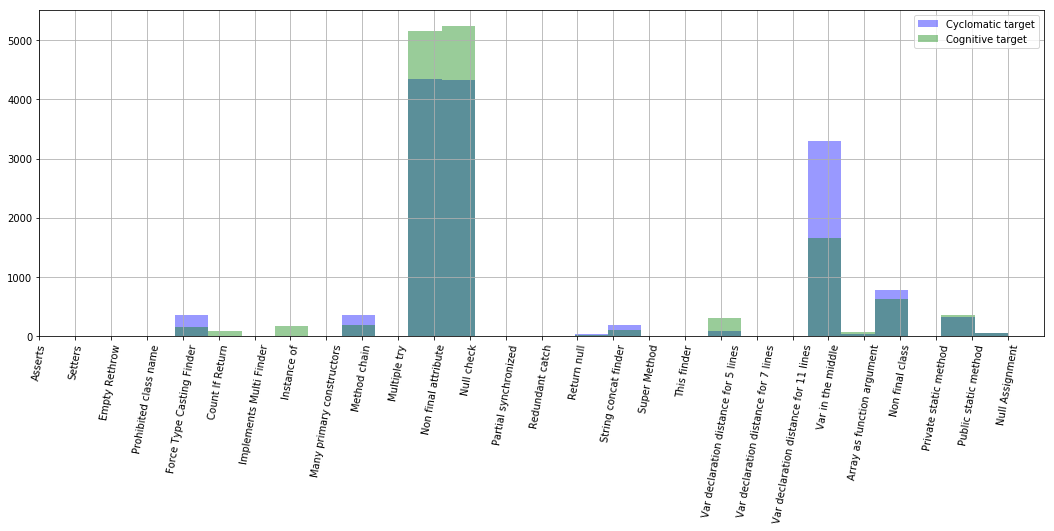

In [23]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log[:, 0], label='Cyclomatic target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
sns.distplot(twofold_pred_log0[:, 0], label='Cognitive target', bins = FEATURES_NUMBER, hist = True, kde=False, color='green')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS, rotation=80)
plt.legend();

In the model we decided to use Cognitive Complexity because distribution of patterns' importances is more balanced.

# Fitting without frequent patterns

According to previous experiments patterns 'Non final class', 'Non final attribute', 'Null check' and 'Var in the middle' are most frequent and important. 

In the experiment we tried to fit model without this patterns and got best distribution of patterns' importances. 

In order to speed up the experiment we used model without grid search because it weakly affects distribution of patterns' importances.

## target - Cognitive Complexity

### 1. Didn't remove patterns

In [111]:
print_scores(y4_test, twofold_model1.model.predict(X_test))

MSE:  0.018161469367715
MAE:  0.09222187440262528


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


MAPE: inf
R2:   0.4791561053511094
VAR:   0.034869314115619894


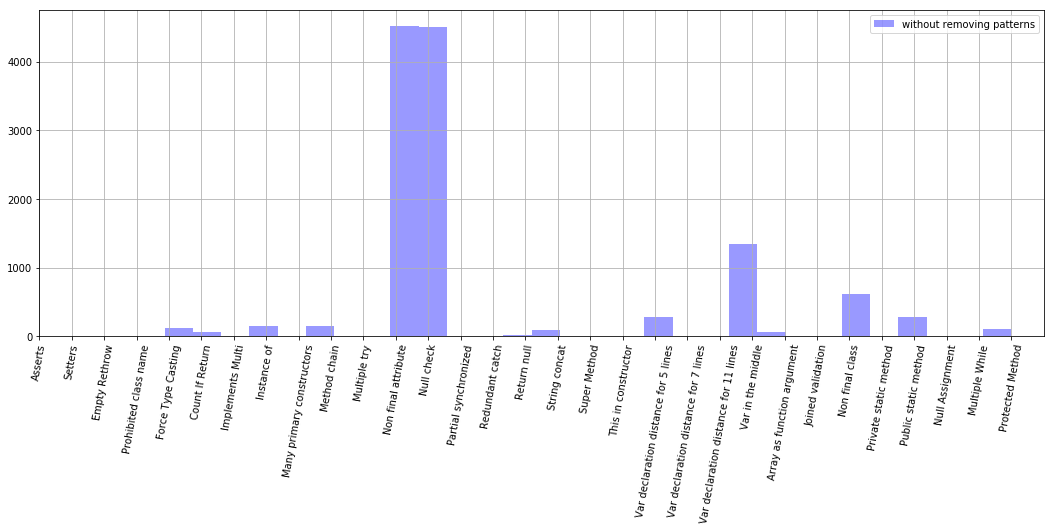

In [112]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='without removing patterns', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS1, rotation=80)
plt.legend();

### 2. removed pattern 'Non final class'

In [128]:
print_scores(y4_test, twofold_model1.model.predict(X_test))

MSE:  0.018092245455823743
MAE:  0.09216362208284529


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


MAPE: inf
R2:   0.4811413440530158
VAR:   0.034869314115619894


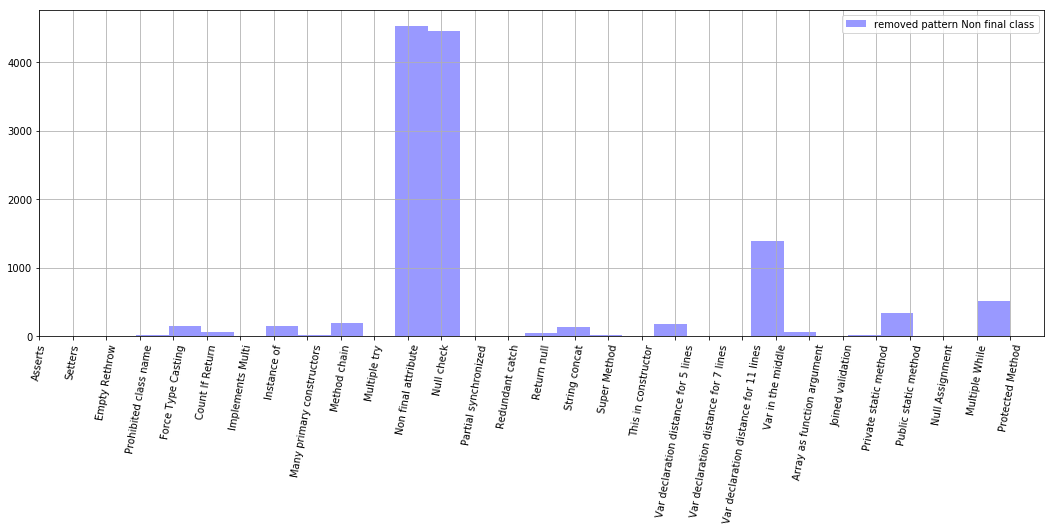

In [129]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='removed pattern Non final class', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS1, rotation=80)
plt.legend();

### 3. removed pattern 'Var in the middle'

In [134]:
print_scores(y4_test, twofold_model1.model.predict(X_test))

MSE:  0.018260974014157695
MAE:  0.09324116918875158


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


MAPE: inf
R2:   0.4763024602775999
VAR:   0.034869314115619894


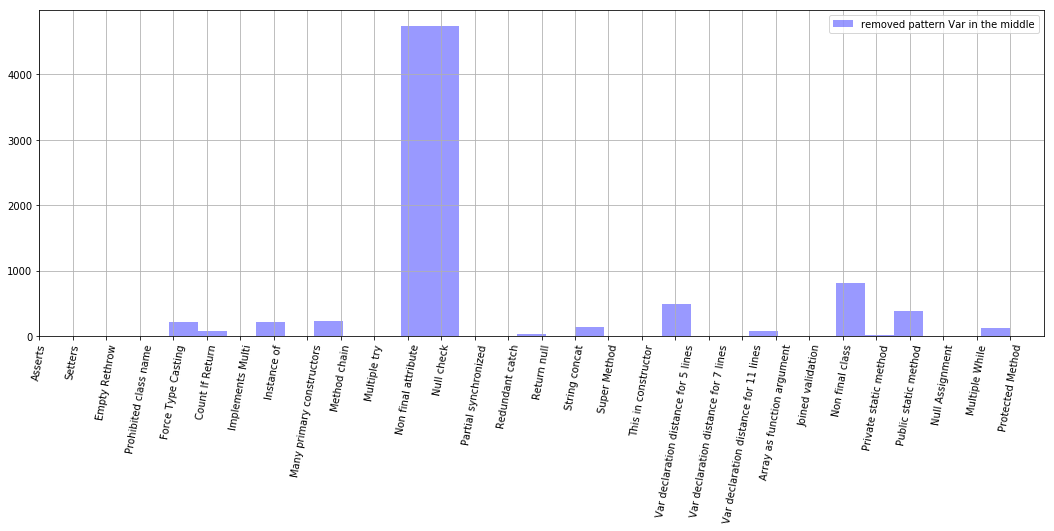

In [135]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='removed pattern Var in the middle', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS1, rotation=80)
plt.legend();

### 4. removed pattern 'Non final attribute'

In [119]:
print_scores(y4_test, twofold_model1.model.predict(X_test))

MSE:  0.019545684129173096
MAE:  0.09927510956467074


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


MAPE: inf
R2:   0.4394588874228098
VAR:   0.034869314115619894


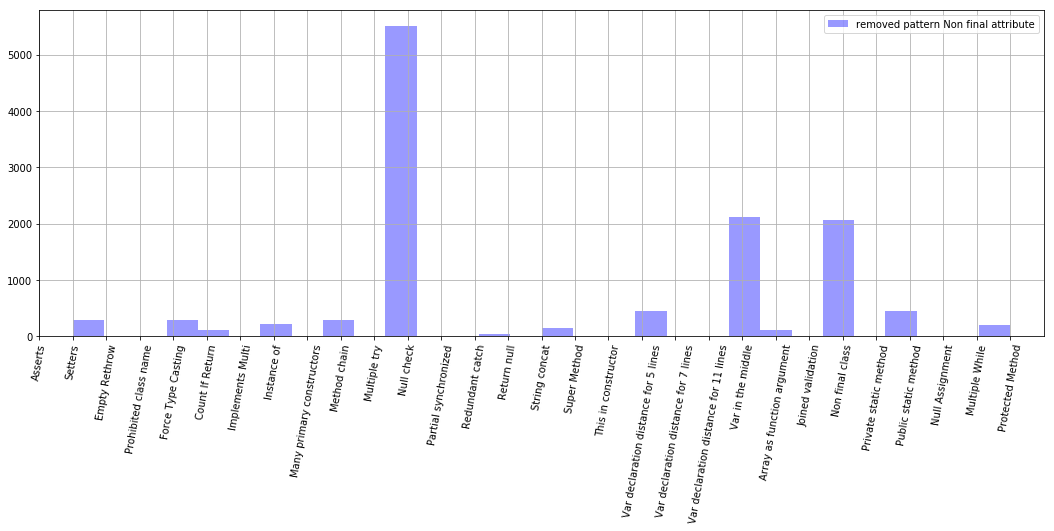

In [120]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='removed pattern Non final attribute', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS1, rotation=80)
plt.legend();

### 5. removed pattern 'Null check'

In [141]:
print_scores(y4_test, twofold_model1.model.predict(X_test))

MSE:  0.02086117997686352
MAE:  0.09996621680938785


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


MAPE: inf
R2:   0.4017324256022964
VAR:   0.034869314115619894


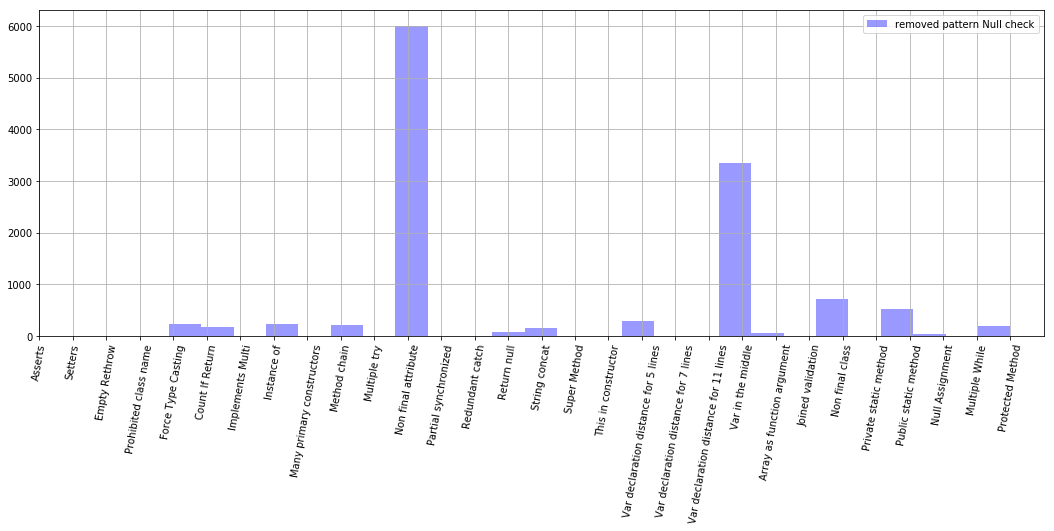

In [142]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='removed pattern Null check', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS1, rotation=80)
plt.legend();

### 6. removed all 4 patterns

In this experiment we got best distribution of patterns' importances

In [148]:
print_scores(y4_test, twofold_model1.model.predict(X_test))

MSE:  0.02371259815995479
MAE:  0.11252327232661688


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


MAPE: inf
R2:   0.31995799856204776
VAR:   0.034869314115619894


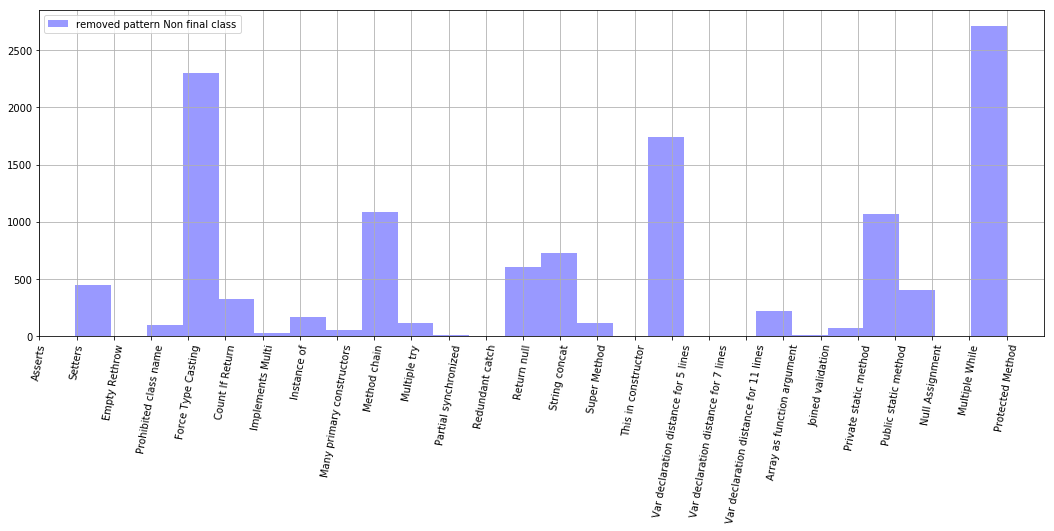

In [149]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='removed pattern Non final class', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS1, rotation=80)
plt.legend();

# Results' analysis

Need to check how quality of our model changed.

In [153]:
mse_new = 0.02371259815995479 # removed 4 patterns  
mse_old = 0.018161469367715 # without removing patterns 

In [155]:
mse_new / mse_old

1.3056541670635877

In [157]:
mae_new = 0.11252327232661688
mae_old = 0.09222187440262528

In [158]:
mae_new / mae_old

1.220136470392687

Quality of prediction complexity down by 20-30 %, but we got more balanсed distribution of patterns' importances.

-----------------------------------------